In [ ]:
!pip list

In [ ]:
!pip install keras keras-cv matplotlib opencv-python pillow pycocotools tensorflow tensorflow-metal

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import numpy as np
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import tqdm

Using TensorFlow backend


In [2]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

2024-02-21 00:58:04.431118: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-02-21 00:58:04.431143: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-02-21 00:58:04.431149: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-02-21 00:58:04.431189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-21 00:58:04.431205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/brian/code/osu/cs461/keras/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This prop

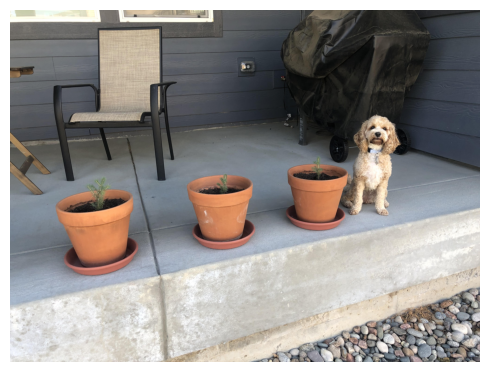

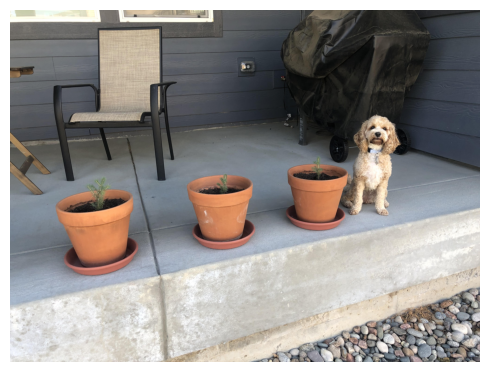

In [3]:
filepath = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [4]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [5]:
image_batch = inference_resizing([image])

In [6]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

2024-02-21 00:58:15.385711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


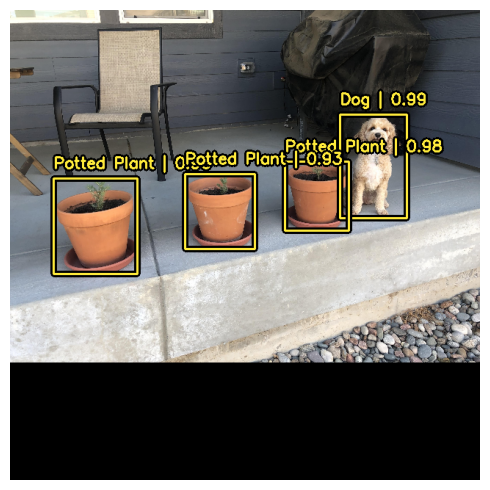

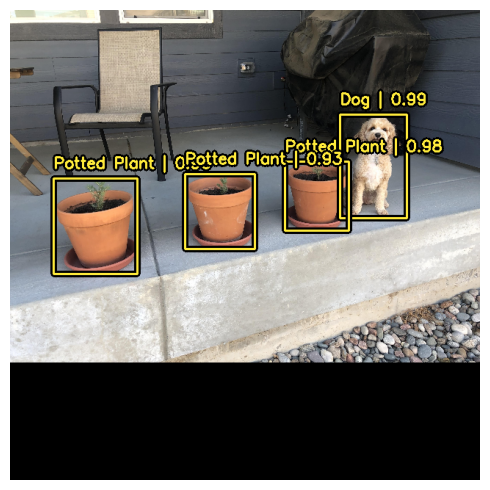

In [7]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 [==============================] - 3s 3s/step


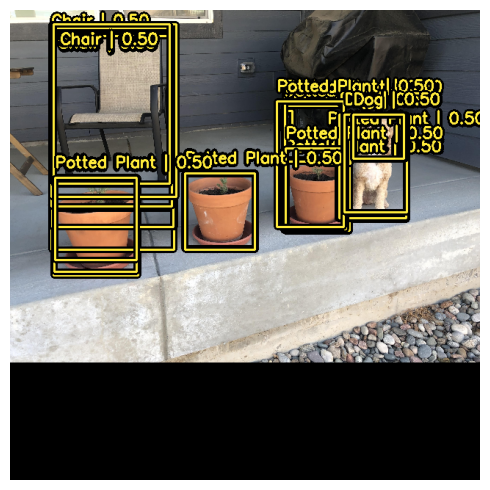

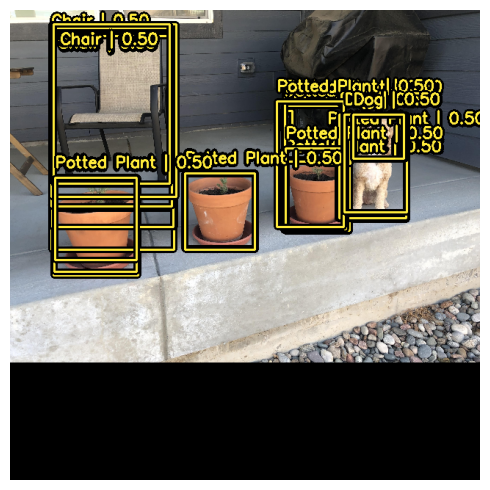

In [8]:
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 [==============================] - 3s 3s/step


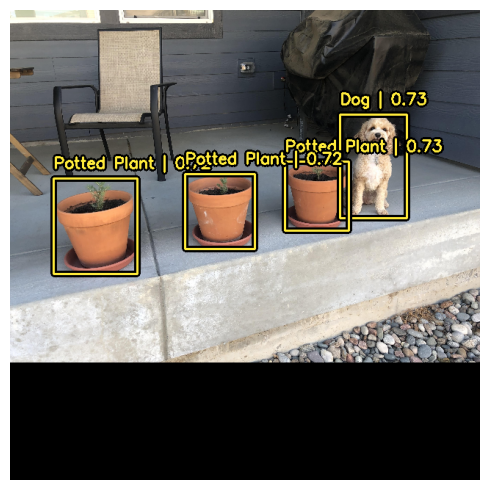

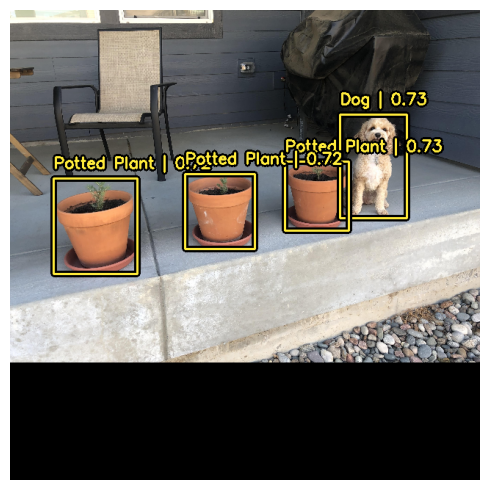

In [9]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [10]:
BATCH_SIZE = 4

In [11]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds

train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [12]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

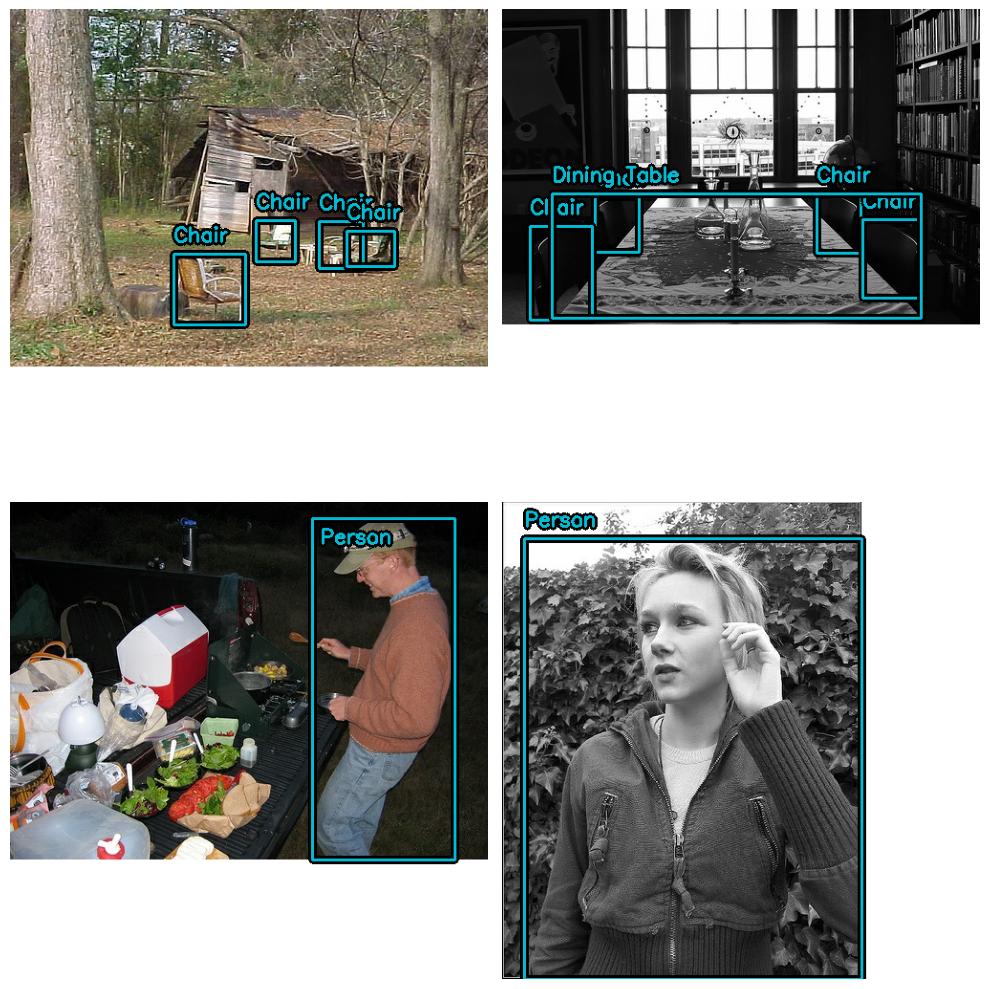

In [13]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

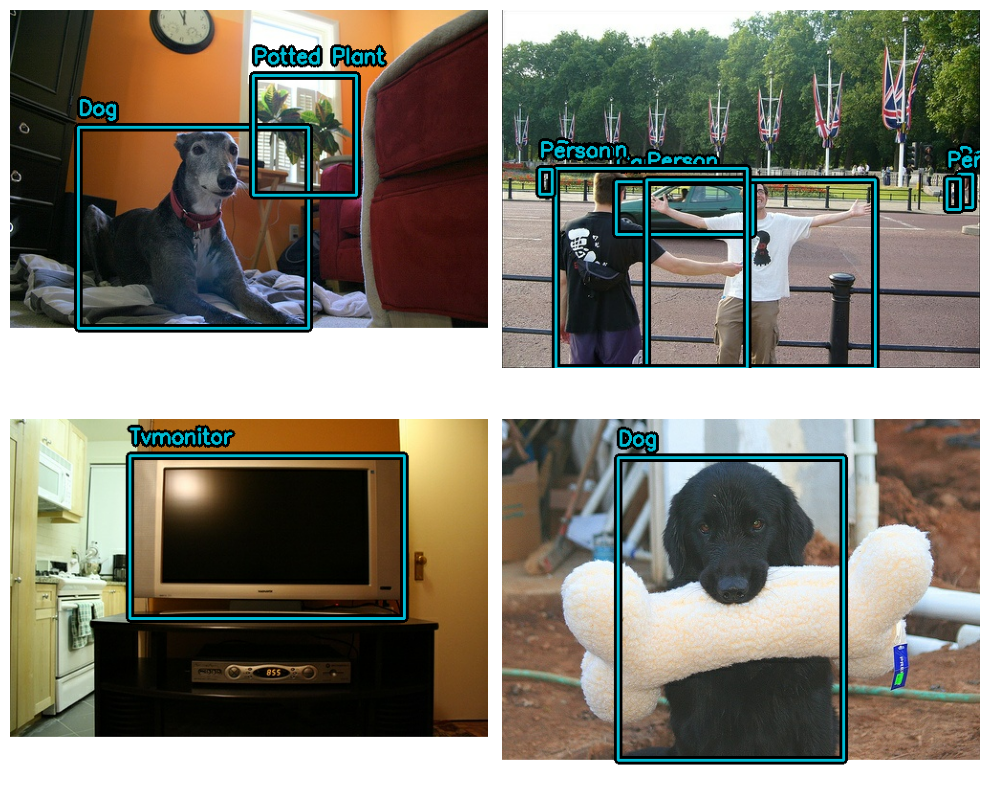

In [14]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

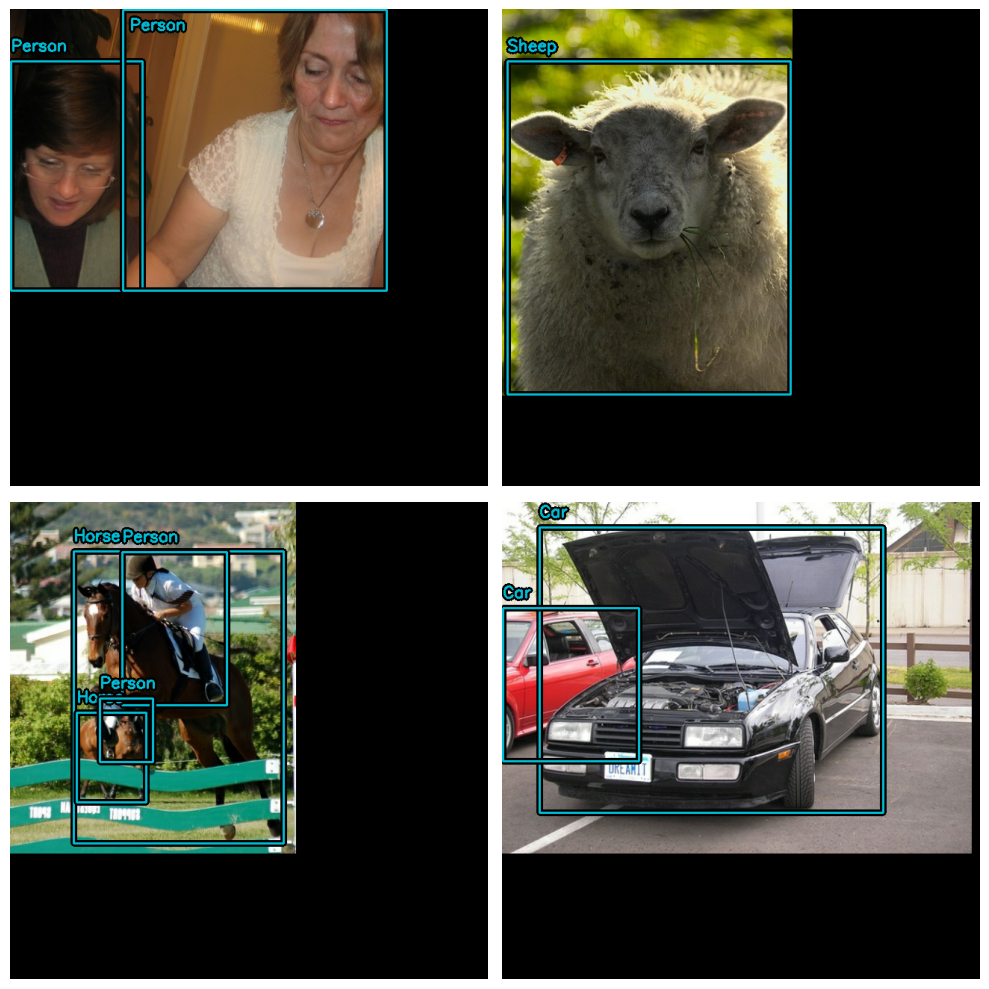

In [15]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [16]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

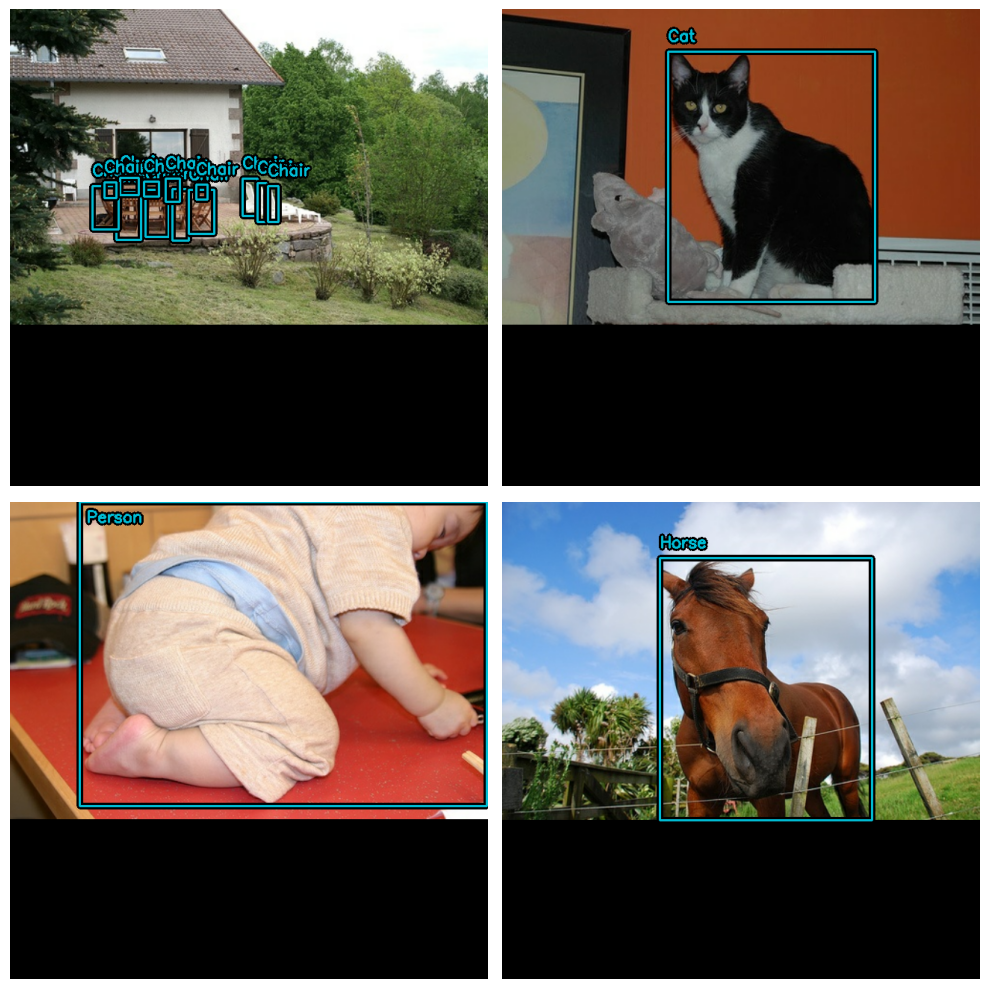

In [17]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [18]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

In [19]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks

# 2024.02.21 bd:
# got the following error when the next line used keras.optimizers.SGD:
#
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
#
# so I've changed it to use legacy.SGD
optimizer = keras.optimizers.legacy.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [20]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [21]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [22]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 777/777 [00:00<00:00, 1.04MB/s]
100%|██████████| 90.3M/90.3M [00:03<00:00, 27.0MB/s]
/Users/brian/code/osu/cs461/keras/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs461/keras/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [23]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [24]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

20/20 [==============================] - 11s 350ms/step: 318.3435 -
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Recall

In [25]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

In [26]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [27]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 6s 6s/step


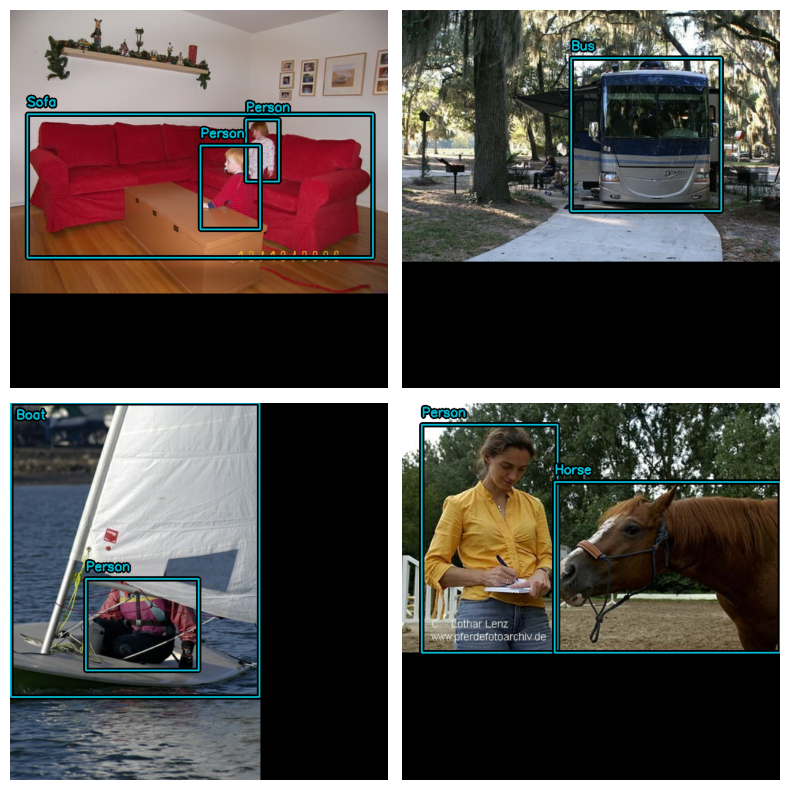

In [28]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

In [29]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )

In [ ]:
stable_diffusion = keras_cv.models.StableDiffusionV2(512, 512)
images = stable_diffusion.text_to_image(
    prompt="A zoomed out photograph of a cool looking cat.  The cat stands in a beautiful forest",
    negative_prompt="unrealistic, bad looking, malformed",
    batch_size=4,
    seed=1231,
)
encoded_predictions = model(images)
y_pred = model.decode_predictions(encoded_predictions, images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    y_pred=y_pred,
    rows=2,
    cols=2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL
 371941376/1361968152 [=======>......................] - ETA: 28s